El objetivo de esta práctica guiada es comprobar la implementación de un algoritmo k-medias. En concreto, se va a emplear el dataset cost-of-living, con los costes en EUR de distintos elementos en varias ciudades como  indicadores del nivel de vida de las mismas. El dataset incluye un total de 55 elementos para 161 ciudades.  

El algoritmo k-medias de agrupación es un no supervisado, por lo que no existe variable dependiente (a predecir). Nuestro objetivo es agrupar las ciudades en función de que tengan un coste de la vida sea parecido y ver qué ciudades hay en cada grupo.



In [1]:
# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean

# Descargar el dataset
url = 'https://github.com/crisurdiales/DataMining4SmartCities/raw/main/cost-of-living.csv'
coste_ciudades = pd.read_csv(url)

# Mostrar resumen del dataset
print(coste_ciudades.describe())

(55, 161)
       Saint Petersburg, Russia  Istanbul, Turkey  Izmir, Turkey  \
count                 55.000000         55.000000      55.000000   
mean                 947.569636       1030.352000     973.539818   
std                 3689.965894       4357.787422    4320.550584   
min                    0.030000          0.110000       0.090000   
25%                    0.950000          0.855000       0.750000   
50%                    4.400000          3.820000       3.060000   
75%                   73.370000         43.365000      37.700000   
max                19305.290000      24443.150000   24443.150000   

       Helsinki, Finland  Chisinau, Moldova  Milan, Italy  Cairo, Egypt  \
count          55.000000          55.000000     55.000000     55.000000   
mean         1235.551636         726.469091   1400.266909    939.282727   
std          4477.879943        3173.541506   4600.941958   4371.550743   
min             0.070000           0.070000      0.180000      0.010000   
25

Por comodidad para trabajar, vamos a trasponer el dataframe, de forma que cada ciudad sea una fila y las variables ocupen columnas.

In [3]:
def trasponer_dataframe(df):
    nombrevariables = df.iloc[:, 0].values
    df_trans = df.iloc[:, 1:].transpose()
    df_trans.columns = nombrevariables
    return df_trans

kmeans_df = trasponer_dataframe(coste_ciudades)
print(kmeans_df.head())

                          Meal, Inexpensive Restaurant  \
Saint Petersburg, Russia                          7.34   
Istanbul, Turkey                                  4.58   
Izmir, Turkey                                     3.06   
Helsinki, Finland                                12.00   
Chisinau, Moldova                                 4.67   

                          Meal for 2 People, Mid-range Restaurant, Three-course  \
Saint Petersburg, Russia                                              29.35       
Istanbul, Turkey                                                      15.28       
Izmir, Turkey                                                         12.22       
Helsinki, Finland                                                     65.00       
Chisinau, Moldova                                                     20.74       

                          McMeal at McDonalds (or Equivalent Combo Meal)  \
Saint Petersburg, Russia                                            4.40   


El algoritmo k-means intenta establecer tantos clusters como indique k, procurando mantener cada cluster coherente y tan disinto de los demás como sea posible. Por ejemplo, podemos aplicarlo a 10 clusters. n_init indica cuantas veces se ejecutará el algoritmo para diferentes inicializaciones de los centroides -la función luego se quedará el mejor resultado- y random_state controla la aleatoriedad de la inicialización de los centroides, para garantizar la reproducibilidad de los resultados.

En kmeans.labels_ tendremos a qué clase pertenece cada ciudad.

In [4]:
# Clusterización con K-means
np.random.seed(20)
k = 10
kmeans = KMeans(n_clusters=k, n_init=20, random_state=20)
kmeans.fit(kmeans_df)
labels = kmeans.labels_


Ahora podemos comprobar si tiene sentido la agrupación, mirando, por ejemplo, si las ciudades que caen en un cluster cualquiera son coherentes.

In [13]:
cluster_number = 5
cities_in_cluster = kmeans_df[kmeans_df['Cluster'] == cluster_number].index
print(f"Cities in cluster {cluster_number}:")
print(cities_in_cluster.tolist())

Cities in cluster 1:
['Milan, Italy', 'Kathmandu, Nepal', 'Hanoi, Vietnam', 'Ho Chi Minh City, Vietnam', 'Rome, Italy', 'Amsterdam, Netherlands', 'Paris, France', 'Eindhoven, Netherlands', 'Rotterdam, Netherlands', 'Utrecht, Netherlands', 'Austin, TX, United States', 'Singapore, Singapore', 'Toronto, Canada', 'Tokyo, Japan', 'Boston, MA, United States', 'Chicago, IL, United States', 'Oslo, Norway', 'Frankfurt, Germany', 'Hamburg, Germany', 'Houston, TX, United States', 'Munich, Germany', 'London, United Kingdom', 'Los Angeles, CA, United States', 'Seoul, South Korea', 'Kuala Lumpur, Malaysia', 'New York, NY, United States', 'Copenhagen, Denmark', 'Colombo, Sri Lanka', 'Hong Kong, Hong Kong', 'Portland, OR, United States', 'Lisbon, Portugal', 'Beijing, China', 'Porto, Portugal', 'San Diego, CA, United States', 'San Francisco, CA, United States', 'Seattle, WA, United States', 'Vienna, Austria', 'Montevideo, Uruguay', 'Tel Aviv-Yafo, Israel', 'Taipei, Taiwan', 'Shanghai, China', 'Bangkok,

Evidentemente, no se debe escoger k al azar, sino con cierto criterio, como maximizar la homogeneidad de cada clase (cohesión), la distancia entre ellas (separabilidad) o ambas cosas a la vez. Esto último se puede evaluar usando, por ejemplo, el Indice de Davies-Bouldin (DB).

Para escoger un k apropiado, por tanto, podemos obtener DB para un número incremental de clases, en el código a continuación entre 2 y 20, pero podría ser más dependiendo del dataframe de trabajo) y buscar donde se encuentra el valor mínimo. Esto es, conforme incrementamos el número de clases, los elementos distintos pueden acomodarse mejor, pero a partir de un punto determinado, ya no hay mejoras significativas. La función bestkCluster encuentra ese valor mínimo.

In [37]:
def bestkCluster(dataframe, min_cluster_number, max_cluster_number):
    historico_a = []
    smallest = np.inf
    clusternumber = 0
    totalm = dataframe.values

    for k in range(min_cluster_number, max_cluster_number + 1):
        a = np.inf
        for _ in range(50):
            kmeans = KMeans(n_clusters=k, n_init=20, random_state=20)
            labels = kmeans.fit_predict(totalm)
            score = davies_bouldin_score(totalm, labels)
            if score < a:
                a = score
        historico_a.append(a)
        if a < smallest:
            smallest = a
            clusternumber = k

    # Corrección aquí: asegurarse de que el rango de x coincida con el rango de clusters probados
    plt.plot(range(min_cluster_number, max_cluster_number + 1), historico_a)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Davies-Bouldin Score')
    plt.title('Davies-Bouldin Score for Different Number of Clusters')
    plt.show()

    return clusternumber


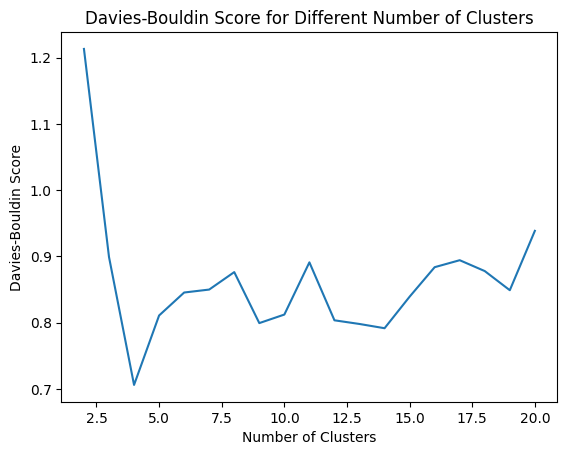

Best number of clusters: 4


In [19]:
# Encontrar el mejor número de clusters
clusternumber = bestkCluster(kmeans_df, 2, 20)
print(f"Best number of clusters: {clusternumber}")

Ahora si podemos ejecutar KMeans con el valor obtenido de k, en este caso 4.

In [20]:
kmeans = KMeans(n_clusters=clusternumber, n_init=20, random_state=20)
kmeans.fit(kmeans_df)
labels = kmeans.labels_
kmeans_df['Cluster'] = labels


Si nos interesa, podemos analizar la distancia entre los centroides de los clusters para evaluar cómo de distintos son. Dichos centroides están en el array centroids.

In [29]:
centroids = kmeans.cluster_centers_

# Distancia entre los centroides de los clusters
for i in range(clusternumber):
    for j in range(i + 1, clusternumber):
        print(f"Distancia entre centroide {i + 1} y {j + 1}: {euclidean(centroids[i], centroids[j])}")

Distancia entre centroide 1 y 2: 14752.623476862747
Distancia entre centroide 1 y 3: 79827.32901761272
Distancia entre centroide 1 y 4: 16983.1816776833
Distancia entre centroide 2 y 3: 73878.09314753456
Distancia entre centroide 2 y 4: 17783.181782304844
Distancia entre centroide 3 y 4: 63029.59903582174
                      Meal, Inexpensive Restaurant  \
Singapore, Singapore                          8.33   

                      Meal for 2 People, Mid-range Restaurant, Three-course  \
Singapore, Singapore                                              39.98       

                      McMeal at McDonalds (or Equivalent Combo Meal)  \
Singapore, Singapore                                            5.33   

                      Domestic Beer (0.5 liter draught)  \
Singapore, Singapore                               6.66   

                      Imported Beer (0.33 liter bottle)  \
Singapore, Singapore                                8.0   

                      Coke/Pepsi (0.33 lit

Se pueden analizar cuantas ciudades hay en cada cluster. Se verá que salen valores bastante distintos, incluso hay un cluster con una única ciudad.

In [27]:
unique, counts = np.unique(labels, return_counts=True)
count_dict = dict(zip(unique, counts))
print(counts)

[105  34   1  20]


Si comprobamos de qué ciudad se trata, es Singapur que, efectivamente, es muy particular, en tanto que se trata de una ciudad-estado con un gobierno complemtamente centralizado.

In [28]:
cluster_number = 2
cities_in_cluster = kmeans_df[kmeans_df['Cluster'] == cluster_number].index
print(f"Cities in cluster {cluster_number}:")
print(cities_in_cluster.tolist())

Cities in cluster 2:
['Singapore, Singapore']


En cuanto a los clusters más numerosos, el 1 recoge a muchas ciudades de Europa, Canadá, Korea y grandes ciudades de EEUU y Australia, el 3 otras ciudades de Europa -principalmente Paises Bajos y Nórdicos y Portugal- junto con Israel y otras países como Jordania, Vietnam o Jakarta y el 0 incluye al resto. Parece una mezcla un tanto ecléctica y más adelante comentaremos una posible razón.  

In [67]:
cluster_number = 3
cities_in_cluster = kmeans_df[kmeans_df['Cluster'] == cluster_number].index
print(f"Cities in cluster {cluster_number}:")
print(cities_in_cluster.tolist())

Cities in cluster 3:
['Kathmandu, Nepal', 'Hanoi, Vietnam', 'Ho Chi Minh City, Vietnam', 'Eindhoven, Netherlands', 'Rotterdam, Netherlands', 'Utrecht, Netherlands', 'Oslo, Norway', 'Kuala Lumpur, Malaysia', 'Copenhagen, Denmark', 'Colombo, Sri Lanka', 'Lisbon, Portugal', 'Porto, Portugal', 'Montevideo, Uruguay', 'Tel Aviv-Yafo, Israel', 'Bangkok, Thailand', 'Reykjavik, Iceland', 'Amman, Jordan', 'Dublin, Ireland', 'Jakarta, Indonesia', 'Jerusalem, Israel']


In [30]:
# Análisis de ciudades específicas dentro de un cluster
print(kmeans_df[kmeans_df['Cluster'] == 2])

                      Meal, Inexpensive Restaurant  \
Singapore, Singapore                          8.33   

                      Meal for 2 People, Mid-range Restaurant, Three-course  \
Singapore, Singapore                                              39.98       

                      McMeal at McDonalds (or Equivalent Combo Meal)  \
Singapore, Singapore                                            5.33   

                      Domestic Beer (0.5 liter draught)  \
Singapore, Singapore                               6.66   

                      Imported Beer (0.33 liter bottle)  \
Singapore, Singapore                                8.0   

                      Coke/Pepsi (0.33 liter bottle)  \
Singapore, Singapore                            1.25   

                      Water (0.33 liter bottle)   Milk (regular), (1 liter)  \
Singapore, Singapore                        0.91                       2.04   

                      Loaf of Fresh White Bread (500g)  Eggs (regular) (12)  

Dado que tenemos 55 variables, para representar los resultados gráficamente sería necesario utilizar algún método de reducción de dimensiones, por ejemplo, PCA. A continuación mostramos los clusters de las ciudades en función de sus dos primeras componentes.

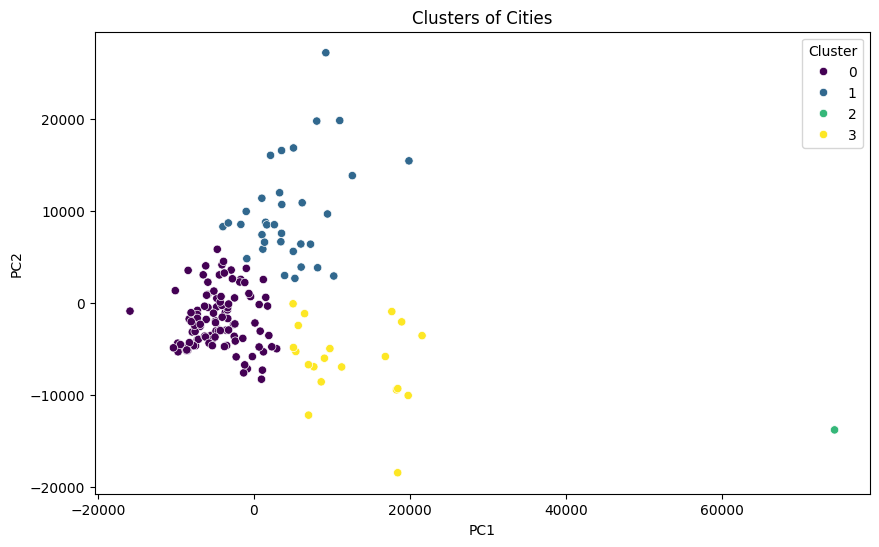

In [24]:
# Visualización de los clusters en 2D utilizando PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(kmeans_df.drop('Cluster', axis=1))
pc_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pc_df['Cluster'] = labels

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pc_df, palette='viridis')
plt.title('Clusters of Cities: k=4')
plt.show()


Para comprender los resultados de la agrupación, odría valorarse que hay variables que pesan mucho más en los datos que otras, dado que se está trabajando con el valor de un litro de leche, un coche o la educación anual de un hijo en un centro privado. En muchas medidas de distancia, cambios en estas variables eclipsan el efecto de similitud en el resto. Para tratar esta variabilidad, es usual llevar a cabo el clusteríng **después** de escalar los datos.

Repitamos los pasos para comprobar los resultados con preescalado.

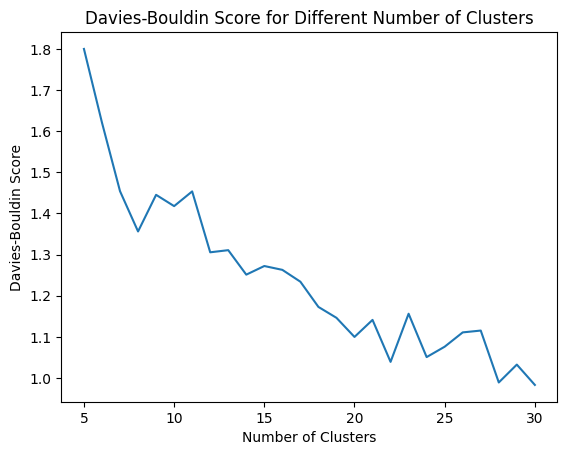

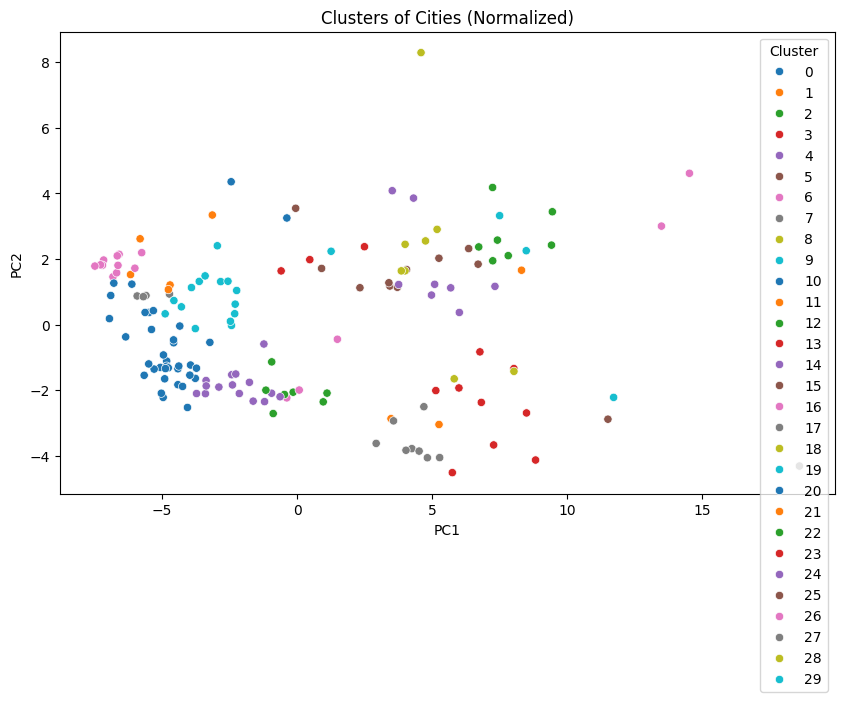

In [39]:
scaler = StandardScaler()
kmeans_df_scaled = pd.DataFrame(scaler.fit_transform(kmeans_df.drop('Cluster', axis=1)), columns=kmeans_df.columns[:-1])

clusternumber_scaled = bestkCluster(kmeans_df_scaled, 5,30)


Lo que observamos ahora es que DB no presenta un mínimo claro, sino que sigue disminuyendo globalmente conforme aumentamos el número de clusters. Porbablemente, con anterioridad estaban pesando mucho más en la separación los elementos con precios más altos, lo que permitía un resultado mucho más claro, pero en este caso la división no es tan obvia.

Observando el gráfico, podríamos forzar manualmente el 22, ya que es un mínimo local, aunque en realidad deberíamos seguir analizando más tiempo hasta dar con el valor adecuado.

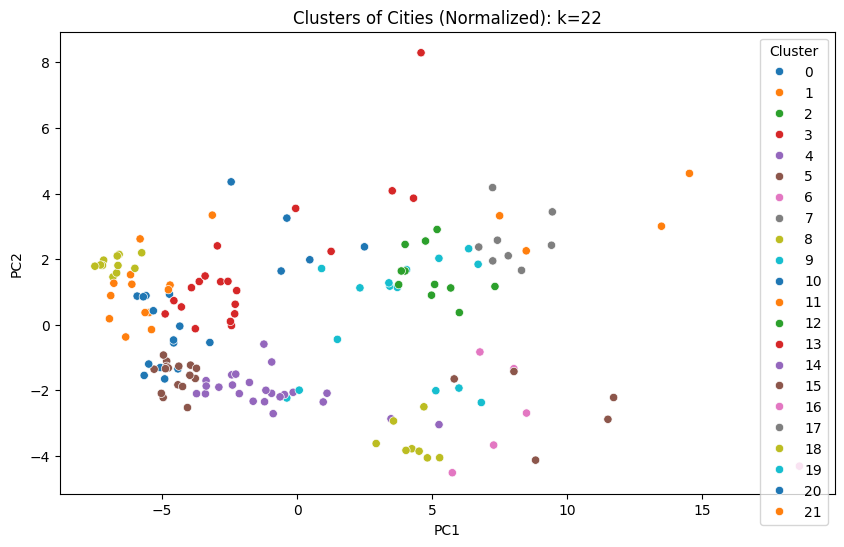

In [41]:
kmeans_scaled = KMeans(n_clusters=22, n_init=20, random_state=20)
kmeans_scaled.fit(kmeans_df_scaled)
labels_scaled = kmeans_scaled.labels_
kmeans_df_scaled['Cluster'] = labels_scaled

# Visualización después de la normalización
pca_scaled = PCA(n_components=2)
principal_components_scaled = pca_scaled.fit_transform(kmeans_df_scaled.drop('Cluster', axis=1))
pc_df_scaled = pd.DataFrame(data=principal_components_scaled, columns=['PC1', 'PC2'])
pc_df_scaled['Cluster'] = labels_scaled

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pc_df_scaled, palette='tab10')
plt.title('Clusters of Cities (Normalized): k=22')
plt.show()

Puede observarse que hay algunos nucleos más numerosos de hasta 15 o 16 ciudades, pero que muchas agrupaciones ya pasan a tener 1 o 2 elementos, por lo que deberían considerarse outliers.

In [42]:
unique, counts = np.unique(labels_scaled, return_counts=True)
count_dict = dict(zip(unique, counts))
print(counts)

[10 13  6 16 15  5  5  6 11 12  5  2  5  4  9 16  1  2  8  3  4  2]


Por ejemplo, el cluster 11 incluye solo a NYC y San Francisco, 16 sería Zurich y el 17 ahora Singapur junto con Hong Kong. El último cluster incluye a Tokyo y Seul.

Se puede observar que las agrupaciones juntan ciudades que, desde un punto de vista cualitativo, pueden ser más parecidas en cultura, sociedad y precios (desde un punto de vista muy general, evidetemente).

In [60]:
cluster_number = 21
cities_in_cluster = kmeans_df_scaled[kmeans_df_scaled['Cluster'] == cluster_number].index
print(f"Cities in cluster {cluster_number}:")
print(cities_in_cluster.tolist())
print(kmeans_df.iloc[cities_in_cluster].index)

Cities in cluster 21:
[44, 73]
Index(['Tokyo, Japan', 'Seoul, South Korea'], dtype='object')


Si en lugar de los "outliers" nos centramos en las agrupaciones más numerosas, el bloque 0 incluye ciudades de Rusia y Ucrania (aunque también Buenos Aires), el 1 junta Egipto, Vietnam, Tunez y las ex-repúblicas soviéticas de Asia Central, el 4 capitales de Europa del Este y repúblicas Bálticas (generalmente las capitales presentan costes de vida distintos del resto de las ciudades), el 5 paises nórdicos, Islandia e Israel y así sucesivamente.

In [64]:
cluster_number = 5
cities_in_cluster = kmeans_df_scaled[kmeans_df_scaled['Cluster'] == cluster_number].index
print(f"Cities in cluster {cluster_number}:")
print(cities_in_cluster.tolist())
print(kmeans_df.iloc[cities_in_cluster].index)

Cities in cluster 5:
[50, 79, 120, 128, 154]
Index(['Oslo, Norway', 'Copenhagen, Denmark', 'Tel Aviv-Yafo, Israel',
       'Reykjavik, Iceland', 'Jerusalem, Israel'],
      dtype='object')
